# Starting Off

"A Tough Battle Ended in Defeat"

Imagine the the text above was a headline for an article.  Do you believe this article would be about sports or politics? Why?

Discuss with a partner

# Text Classification with Naive Bayes: A practical explanation

The simplest solutions are usually the most powerful ones, and Naive Bayes is a good proof of that.



Naive Bayes is a family of probabilistic algorithms that take advantage of probability theory and Bayes’ Theorem to predict the class of an observation.  



The alogrithm uses Bayes' Theorem to calculate the probablity of an instane belonging to a specific class, based on prior knowledge of the conditions related to that instance.

We’re going to be working with an algorithm called Multinomial Naive Bayes. 

## A Simple Example:

Let's build a text classifier to determine if a headline is related to sports or politics.

### Our Data

![sample data](NB_sample_data.png)

Now, which tag does the sentence "A very close game" belong to?

We want to find the probability that the tag of a sentence is Sports given that the sentence is “A very close game”.

Mathematically speaking:

![nb_sports](simplemodel.png)

### Feature Engineering

In this case though, we don’t even have numeric features. We just have text. We need to somehow convert this text into numbers that we can do calculations on. 

Thoughts?

We use word frequencies. That is, we ignore word order and sentence construction, treating every document as a set of the words it contains. Our features will be the counts of each of these words.

| Text                  | Tag        |
|-----------------------|------------|
| A great game          | Sports     |
| The election was over | Not Sports |
| Very clean match      | Sports     |
| A clean but forgettable game| Sports|
| It was a close election| Not Sports|


| Text       | Sports  | Politics |
|------------|--------------|---------------|
| a          |              |               |
| great      |              |               |
| game       |              |               |
| the        |              |               |
| election   |              |               |
| was        |              |               |
| over       |              |               |
| very       |              |               |
| clean      |              |               |
| match      |              |               |   
| but        |              |               |
| forgettable|              |               |
| it         |              |               |
| close      |              |               |


### Bayes' Theorem

Bayes’ Theorem is useful when working with conditional probabilities (like we are doing here), because it provides us with a way to reverse them:

![bayes](bayes.png)

In our case, we have $P(sports | a\, very\, close\, game)$, so using this theorem we can reverse the conditional probability:

![reverse](bayes_game.png)

Since for our classifier we’re just trying to find out which tag has a bigger probability, we can discard the divisor —which is the same for both tags— and just compare:


![sports](bayes_class_sports.png)
with
![politics](bayes_class_politics.png)

Just count how many times the sentence “A very close game” appears in the Sports tag, divide it by the total, and obtain $P(a\, very\, close\, game | Sports)$.

### Being Naive

So here comes the Naive part: we assume that every word in a sentence is independent of the other ones. This means that we’re no longer looking at entire sentences, but rather at individual words. So for our purposes, “this was a fun party” is the same as “this party was fun” and “party fun was this”.

We write this as:

![broken down](broke_down.png)

The next step is just applying this to what we had before:
    
![broke bayes](broken_model.png)

### Calculating probabilities

The final step is just to calculate every probability and see which one turns out to be larger.

## Laplace smoothing: 

In order to work with this data, we use Lapace Smoothing. 

We add 1 to every count so it’s never zero. To balance this, we add the number of possible words to the divisor, so the division will never be greater than 1. In our case, the possible words are 

`['a', 'great', 'very', 'over', 'it', 'but', 'game', 'election', 'clean', 'close', 'the', 'was', 'forgettable', 'match']`.

Since the number of possible words is 14 (I counted them!), applying smoothing we get that 

$P(game | sports) = \dfrac {2 + 1}{11 + 14}$. 



The full results are:

Now we just multiply all the probabilities, and see who is bigger:

![sports calc](sports_calc.png)



Excellent! Our classifier gives “A very close game” the Sports tag.



### Issues with this model?

What are some issues you forsee with this model?


### Advanaced NLP Techniques

- **Removing stopwords**. These are common words that don’t really add anything to the classification, such as a, able, either, else, ever and so on. 
    - *The election was over* =  *election over*  
    - *A very close game*  = *very close game*.

- **Lemmatizing words**. This is grouping together different inflections of the same word.  
    - *election*, *elections*, and *elected* would be grouped together and counted as more appearances of *elect*.

- **Using n-grams** . Instead of counting single words like we did here, we could count sequences of words, like “clean match” and “close election”.

- **Using TF-IDF**. Instead of just counting frequency we could do something more advanced like also penalizing words that appear frequently in most of the texts.

## Now with Code

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [2]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [3]:
print(train.data[5])


From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In order to use this data for machine learning, we need to be able to convert the content of each string into a vector of numbers. For this we will use the TF-IDF vectorizer, and create a pipeline that attaches it to a multinomial naive Bayes classifier:

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

With this pipeline, we can apply the model to the training data, and predict labels for the test data:

In [5]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator. For example, here is the confusion matrix between the true and predicted labels for the test data:

Text(89.133125, 0.5, 'predicted label')

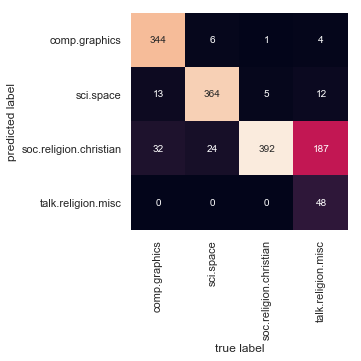

In [6]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [7]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [8]:
predict_category('sending a payload to the ISS')

'sci.space'

In [9]:
predict_category('determining the screen resolution')

'comp.graphics'

In [10]:
predict_category('discussing islam vs atheism')


'soc.religion.christian'

### When to Use Naive Bayes
Because naive Bayesian classifiers make such stringent assumptions about data, they will generally not perform as well as a more complicated model. That said, they have several advantages:

- They are extremely fast for both training and prediction
- They provide straightforward probabilistic prediction
- They are often very easily interpretable
- They have very few (if any) tunable parameters





These advantages mean a naive Bayesian classifier is often a good choice as an initial baseline classification. If it performs suitably, then congratulations: you have a very fast, very interpretable classifier for your problem. If it does not perform well, then you can begin exploring more sophisticated models, with some baseline knowledge of how well they should perform.

Naive Bayes classifiers tend to perform especially well in one of the following situations:

- When the naive assumptions actually match the data (very rare in practice)
- For very well-separated categories, when model complexity is less important
- For very high-dimensional data, when model complexity is less important